# Dynamic optimization

In [1]:
from platform import python_version
print(python_version())

3.8.10


## Testing phase
1. starting from single shots from:
    - https://media.xiph.org/video/derf/
    - ftp://svtopencontent.svt.se

2. coding raw videos in AVC, HEVC, VP9 (in seguito ed eventualmente AV1 e VVC) using:
    - ffmpeg library for AVC, HEVC, VP9 and AV1
    - Fraunhofer Versatile Video Encoder (VVenC) for VVC

3. In this first testing phase we assess the different codecs, quality metrics, complexity of the contents, density and cbr steps by encoding multiple quality versions at different crf values. (see [Encoding Notebook](ENCODE.ipynb))

4. Each of these shot is evaluated through PSNR and VMAF metrics, which are stored inside .json and .csv files togheter with the videos' encoding parameters. (see [Assessment Notebook](ASSESS.ipynb))

In [2]:
# TODO: display plots

## Optimization phase
We suggest two methods for the dynamic optimization of video shots (still not scenes) based on rate-distortion techniques:
1. Curve fitting, approximative but faster
2. Recursive target search, slow and also to test the precision of the prevous one

## 1. Curve fitting
Given the RQ points discover the logarithmic function that describes their trend and find the best crf for a specific target of bitrate or quality.

In [3]:
import json
import numpy as np
from scipy.optimize import curve_fit

def find_closest(arr, val):
    idx = (np.abs(arr - val)).argmin()
    return idx
def log_fit(x, a, b, c):
    return a * np.log(x + b) + c

source = "forest"
filepath = "rd_results/rd_" + source + ".json"
bitrates = []
vmafs = []

with open(filepath, 'r') as r:
    i_data = json.load(r)
for item in i_data:
    if(item["codec"] == "vp9"):
        bitrates.append(item["bitrate"])
        vmafs.append(item["vmaf"])
num_samples = (max(bitrates) - min(bitrates)) / 26

#LOG CURVE FITTING
popt, pcov = curve_fit(log_fit, bitrates, vmafs, maxfev=2000)
xnew = np.arange(min(bitrates), max(bitrates)+num_samples, num_samples)
interp_vmaf = log_fit(xnew, *popt)

#SELECT TARGET
target_bitrate = 12000000
target_vmaf = 98
opt_dist = True
if(opt_dist):
    crf = find_closest(interp_vmaf, target_vmaf)
else:
    crf = find_closest(xnew, target_bitrate)
print(crf + 15)
    

32


/home/ubuntu/video_dynopt/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


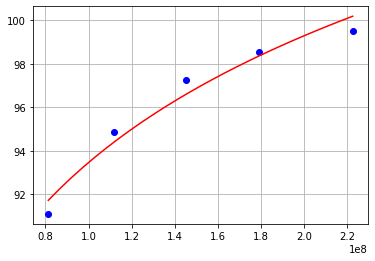

In [4]:
import matplotlib.pyplot as pl

pl.plot(bitrates, vmafs, 'bo')
pl.plot(xnew, interp_vmaf, 'r')
pl.grid(True)

#TODO: covariance testing, MSE assessment

The same but with RD:

[4230288, 33291461, 13687865, 147758394, 69415444]
[69.45263800000001, 23.869677999999993, 44.853526, 2.746516999999997, 10.516582]
5520311.769230769
15


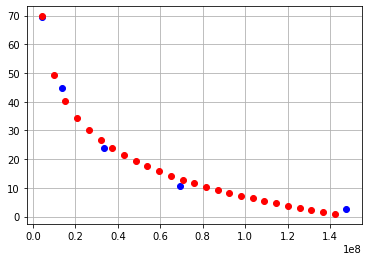

In [75]:
import json
import numpy as np
import matplotlib.pyplot as pl
from scipy.optimize import curve_fit

def find_closest(arr, val):
    idx = (np.abs(arr - val)).argmin()
    return idx
def log_fit(x, a, b, c):
    return a * np.log(x + b) + c

source = "forest"
filepath = "rd_results/rd_" + source + ".json"
bitrates = []
vmafs = []

with open(filepath, 'r') as r:
    i_data = json.load(r)
for item in i_data:
    if(item["codec"] == "hevc"):
        bitrates.append(item["bitrate"])
        vmafs.append(100 - item["vmaf"])
num_samples = (max(bitrates) - min(bitrates)) / 26
print(bitrates)
print(vmafs)
print(num_samples)
#LOG CURVE FITTING
popt, pcov = curve_fit(log_fit, bitrates, vmafs, maxfev=1000)
xnew = np.arange(min(bitrates), max(bitrates), num_samples)
interp_vmaf = log_fit(xnew, *popt)
pl.plot(bitrates, vmafs, 'bo')
pl.plot(xnew, interp_vmaf, 'ro')
pl.grid(True)

#OPT
opt_rd = np.sqrt(np.add(np.asarray(np.log(xnew))**2, np.asarray(interp_vmaf)**2))

#SELECT TARGET
target_bitrate = 12000000
target_vmaf = 98
opt_dist = True
if(opt_dist):
    crf = find_closest(interp_vmaf, target_vmaf)
else:
    crf = find_closest(xnew, target_bitrate)
print(crf + 15)

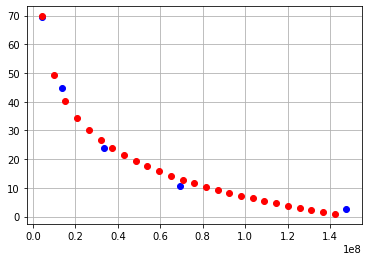

In [71]:
import matplotlib.pyplot as pl

pl.plot(bitrates, vmafs, 'bo')
pl.plot(xnew, interp_vmaf, 'ro')
pl.grid(True)

#TODO: linear inverse testing

## 2. Search
- Encode the first video at a fixed crf
- Encode two more versions with a +- delta of crf
- Compute VMAF quality metrics
- From RQ to RD points
- Which one of these three points is closer to the origin?
    - if it's the one in the middle reduce delta and repeat
    - if it's one of the outer, encode just one another video, with the same delta, in that direction
- Repeat until no more discrete crfs in between